# Y a-t-il des différences selon l'âge et le genre dans la fréquence à laquelle on fait des cauchemars ?

**Author** : Laetitia Carli

**Date** : June 2025

## 1. Library import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import networkx as nx
from statsmodels.miscmodels.ordinal_model import OrderedModel

## 2. Directed acyclic graph

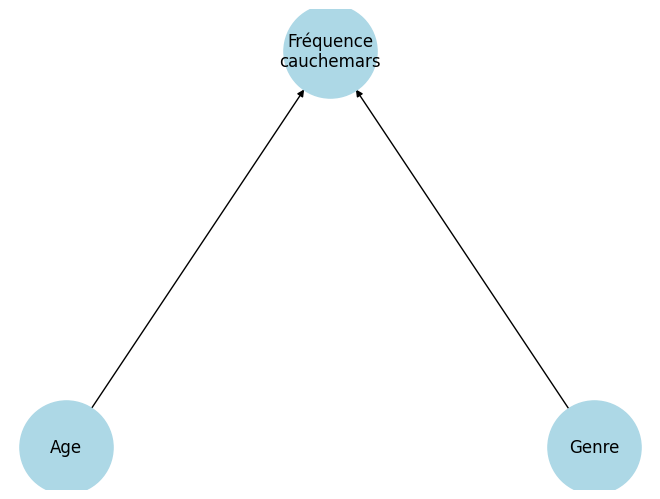

In [2]:
G = nx.DiGraph()

nodes = ['Age', 'Genre','Fréquence\ncauchemars']
G.add_nodes_from(nodes)

edges = [('Age', 'Fréquence\ncauchemars'), ('Genre', 'Fréquence\ncauchemars')]
G.add_edges_from(edges)

pos = nx.planar_layout(G)
nx.draw(G, pos, with_labels = True, node_size = 4500, node_color ='lightblue', arrows = True, font_size = 12)
plt.show()

## 3. Data import 

In [3]:
df = pd.read_csv("questionnaire_dataset.csv", encoding='utf-8')
df

Horodateur Âge (en chiffre) Genre   \
0    04/06/2025 16:15:10               19  Femme   
1    04/06/2025 17:16:08               18  Femme   
2    04/06/2025 17:53:57               19  Femme   
3    12/06/2025 13:59:40               16  Femme   
4    12/06/2025 13:59:55               20  Femme   
..                   ...              ...    ...   
251  17/06/2025 08:18:48               17  Homme   
252  17/06/2025 09:37:34               20  Femme   
253  17/06/2025 10:19:54               21  Femme   
254  18/06/2025 13:13:12               19  Femme   
255  18/06/2025 23:03:37               47  Femme   

    À quelle fréquence avez-vous des sentiments de déjà-vu ?   \
0                                              Souvent          
1                                         Très souvent          
2                                              Souvent          
3                                             Rarement          
4                                              Souvent          
..                                                 ...          
251                                       Très souvent          
252                                           Rarement          
253                                            Souvent          
254                                           Rarement          
255                                            Souvent          

    A quelle fréquence faites-vous des cauchemars ?  \
0                                    Je ne sais pas   
1                                          Rarement   
2                                          Rarement   
3                                          Rarement   
4                                          Rarement   
..                                              ...   
251                                        Rarement   
252                                        Rarement   
253                                         Souvent   
254                                        Rarement   
255                                        Rarement   

    Les rêves sont une expérience que j'apprécie.   \
0                                           Neutre   
1                                         D'accord   
2                                         D'accord   
3                                         D'accord   
4                              Totalement d'accord   
..                                             ...   
251                                         Neutre   
252                                       D'accord   
253                                       D'accord   
254                                       D'accord   
255                                       D'accord   

    Rêvez-vous en couleur ou en noir et blanc ?  \
0                                Je ne sais pas   
1                                    En couleur   
2                                    En couleur   
3                                    En couleur   
4                                    En couleur   
..                                          ...   
251                                    Les deux   
252                                         NaN   
253                                  En couleur   
254                                  En couleur   
255                                  En couleur   

    Mes rêves ont déjà influencé mes actions.  \
0                                    D'accord   
1                                      Neutre   
2                                    D'accord   
3                                Pas d'accord   
4                         Totalement d'accord   
..                                        ...   
251                                  D'accord   
252                                    Neutre   
253                                  D'accord   
254                                  D'accord   
255                                  D'accord   

    Je me souviens souvent de mes rêves.  \
0                   Pas du tout d'accord   
1       

## 4. Data manipulation

### 4.1 Rename columns

In [4]:
df = df.rename(columns={'Âge (en chiffre)': 'Age'})

In [5]:
df = df.rename(columns={'Genre ': 'Genre'})

In [6]:
df = df.rename(columns={'A quelle fréquence faites-vous des cauchemars ?': 'cauchemars'})

### 4.2 Select and clean the data

In [7]:
df.dropna(subset = ['Age', 'Genre', 'cauchemars'], inplace=True)

In [8]:
age_dict = {"20 ans" : 20,
       "55 ans" : 55,
       "soixante deux ans" : 62,
       "18 ans": 18
              }
df['Age'] = df['Age'].astype(str).str.strip().str.lower()
df.loc[:, 'Age'] = df['Age'].replace(age_dict)


In [9]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')  

In [10]:
df = df[df['Genre'].isin(["Femme", "Homme"])]

In [11]:
df = df[df['cauchemars'] != "Je ne sais pas"]

In [12]:
df.loc[:,'cauchemars'] = df['cauchemars'].replace({'tout les jours': 'tous les jours'})

## 5. Data description

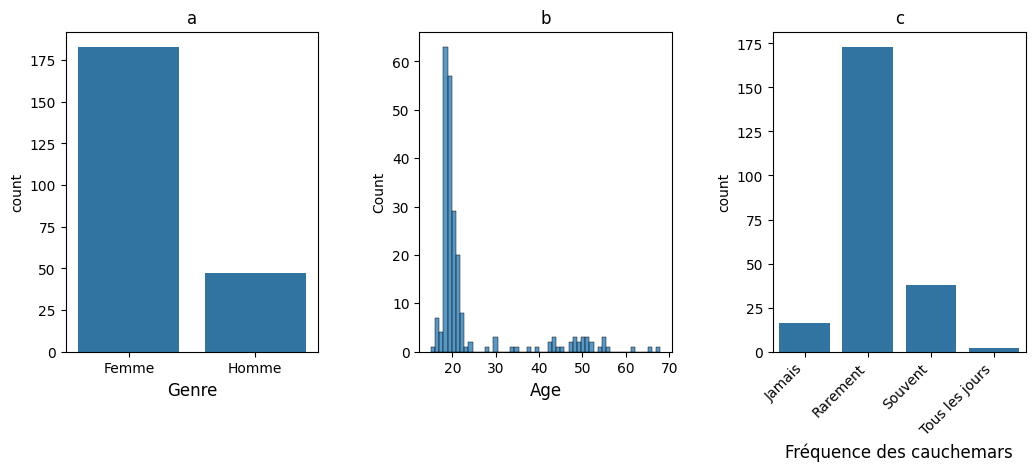

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.countplot(x = df['Genre'], ax = axs[0])
axs[0].set_xlabel("Genre", fontsize = 12)
axs[0].set_title("a")

sns.histplot(x = df['Age'], ax = axs[1])
axs[1].set_xlabel("Age", fontsize = 12)
axs[1].set_title("b")

sns.countplot(x = df['cauchemars'], order=["Jamais",
    "Rarement", "Souvent","Tous les jours", ], ax = axs[2]) 
for tick in axs[2].get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
axs[2].set_xlabel("Fréquence des cauchemars", fontsize = 12)
axs[2].set_title("c")

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

## 6. Data modelling

In [14]:
df.dropna(subset = ['Age', 'Genre', 'cauchemars'], inplace=True)

In [19]:
pd.set_option('future.no_silent_downcasting', True)
df['cauchemars'] = df['cauchemars'].astype(str).str.strip().str.lower()

df['cauchemars'] = df['cauchemars'].replace({
    'tout les jours': 'tous les jours'})

cauchemars_dict = { "jamais": 0,
                    "rarement": 1,
                    "souvent": 2,
                    "tous les jours": 3
                    }
df.loc[:,'cauchemars'] = df['cauchemars'].replace(cauchemars_dict)
df['cauchemars'] = df['cauchemars'].astype('Int64')

In [16]:
model = smf.ols(formula = 'cauchemars ~ Age + Genre', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cauchemars   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.218
Date:                Thu, 19 Jun 2025   Prob (F-statistic):              0.111
Time:                        09:05:03   Log-Likelihood:                -174.46
No. Observations:                 230   AIC:                             354.9
Df Residuals:                     227   BIC:                             365.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.2758      0.082     15.576      0.000       1.114       1.437
Genre[T.Homme]    -0.0630      0.085     -0.739      0.460      -0.231       0.105
Age               -0.0060      0.003     -1.925      0.056      -0.012       0.000
==============================================================================
Omnibus:                       27.651   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.602
Skew:                           0.625   Prob(JB):                     3.78e-12
Kurtosis:                       4.981   Cond. No.                         68.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
df['Genre'] = df['Genre'].astype(str).str.strip().str.lower()
df.loc[:, 'man_encoded'] = df['Genre'].astype('category').cat.codes

In [18]:
y = df["cauchemars"]
X = df[["Age", "man_encoded"]]  

model = OrderedModel(y, X, distr='logit')  
result = model.fit(method='bfgs')


result.summary()

Optimization terminated successfully.
         Current function value: 0.743165
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:             cauchemars   Log-Likelihood:                -170.93
Model:                   OrderedModel   AIC:                             351.9
Method:            Maximum Likelihood   BIC:                             369.0
Date:                Thu, 19 Jun 2025                                         
Time:                        09:05:03                                         
No. Observations:                 230                                         
Df Residuals:                     225                                         
Df Model:                           2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0274      0.014     -1.941      0.052      -0.055       0.000
man_encoded    -0.3426      0.390     -0.877      0.380      -1.108       0.423
0/1            -3.3771      0.472     -7.151      0.000      -4.303      -2.451
1/2             1.4391      0.073     19.822      0.000       1.297       1.581
2/3             1.0353      0.201      5.162      0.000       0.642       1.428
===============================================================================
"""